In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import umap
from adjustText import adjust_text
import re
from scipy.special import softmax
from collections import Counter
from sklearn.cluster import KMeans


In [2]:
# embeddings = open('../../data/all_glove_gensim_word2vec.txt').readlines()

In [3]:
# embeddings = [line.strip() for line in embeddings]

In [4]:
# embedding_dict = {}
# for line in embeddings[1:]:
#     line = line.split()
#     embedding_dict[line[0]] = [float(item) for item in line[1:]]


In [5]:
# pickle.dump(embedding_dict, open('embedding_dict.p', 'wb'))

In [6]:
# embedding_dict = pickle.load(open('embedding_dict.p', 'rb'))

In [7]:
# df_srl_dem = pd.read_csv('srl_dem.tsv', sep='\t')

In [8]:
# df_srl_rep = pd.read_csv('srl_rep.tsv', sep='\t')

In [9]:
# len(df_srl_rep)

In [10]:
# df_srl_emb = df_srl_emb.sample(100000)

In [11]:
def get_args_df(df):   
    args_list_all = []
    for idx, row in df.iterrows():
        annotation = eval(row['Verb_annotation'])
        # extract verb and its embedding
        verb = annotation['verb'].lower()
        text = [t.lower() for t in eval(row['Text'])]
        verb_idx = text.index(verb)
        verb_emb = embedding_dict.get(verb, 0)

        # extract arg0
        arg0_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG0' in tag]
        # if arg0 is too long, may bring trouble
        arg0_emb = []
        if len(arg0_idx) > 0 and len(arg0_idx) <= 3:
            for idx in arg0_idx:
                emb = embedding_dict.get(text[idx], 0) 
                if emb != 0 and len(emb) == 300:
                    arg0_emb.append(emb)
            arg0_emb = np.asarray(arg0_emb)
            if arg0_emb.shape[0] > 1:
                # take the sum of word embeddings
                arg0_emb = np.sum(arg0_emb, axis=0)
                arg0_emb = np.expand_dims(arg0_emb, axis=0)
            try:
                arg0_emb = softmax(arg0_emb)
            except:
                pass
            arg0_tok = [text[idx] for idx in arg0_idx]
            arg0_tok = ' '.join([item for item in arg0_tok])

        else:
            arg0 = 'No_arg0'
            arg0_idx = -1
            arg0_emb = -1
            arg0_tok = 'No_arg0'

        arg1_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG1' in tag]
        arg1_emb = []
        if len(arg1_idx) > 0  and len(arg1_idx) <= 3:
            for idx in arg1_idx:
                emb = embedding_dict.get(text[idx], 0)
                if emb != 0 and len(emb) == 300:
                    arg1_emb.append(emb)
            arg1_emb = np.asarray(arg1_emb)
            if arg1_emb.shape[0] > 1:
                arg1_emb = np.sum(arg1_emb, axis=0)
                arg1_emb = np.expand_dims(arg1_emb, axis=0)
            try:
                arg1_emb = softmax(arg1_emb)
            except:
                pass

            arg1_tok = [text[idx] for idx in arg1_idx]
            arg1_tok = ' '.join([item for item in arg1_tok])


        else:
            arg1 = 'No_arg1'
            arg1_idx = -1
            arg1_emb = -1
            arg1_tok = 'No_arg1'
        if arg0_idx != -1 or arg1_idx != -1:
            args_list_all.append([verb, verb_idx, verb_emb, arg0_tok, arg0_idx, arg0_emb, arg1_tok, \
                                  arg1_idx, arg1_emb])
    return pd.DataFrame(args_list_all, columns=['Verb', 'Verb_idx', 'Verb_emb', 'Arg0_tok', 'Arg0_idx',\
                                               'Arg0_emb', 'Arg1_tok', 'Arg1_idx', 'Arg1_emb'])

In [12]:
# df_args_rep = get_args_df(df_srl_rep)
# pickle.dump(df_args_rep, open('rep_srl_parsed.p', 'wb'))

In [13]:
# df_args_dem = get_args_df(df_srl_dem)
# pickle.dump(df_args_dem, open('dem_srl_parsed.p', 'wb'))

In [15]:
df_args_dem = pickle.load(open('dem_srl_parsed.p', 'rb'))
df_args_rep = pickle.load(open('rep_srl_parsed.p', 'rb'))

In [16]:
len(df_args_rep)

358118

In [17]:
len(df_args_dem)

1342760

In [18]:
for col in ['Verb', 'Arg0_tok', 'Arg1_tok']:
    df_args_rep[col] = df_args_rep[col].apply(lambda x: str(x).encode('utf-8', 'replace').decode('utf-8'))

In [19]:
for col in ['Verb', 'Arg0_tok', 'Arg1_tok']:
    df_args_dem[col] = df_args_dem[col].apply(lambda x: str(x).encode('utf-8', 'replace').decode('utf-8'))

In [20]:
df_args_rep.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,is,4,"[-0.13593, 0.226247, -0.155218, 0.263514, 0.45...",No_arg0,-1,-1,the beauty that,"[1, 2, 3]","[[0.0019967582248604223, 0.0030668990752737374..."
1,tasked,33,"[0.095075, -0.361468, -0.10605, -0.078711, -0....",No_arg0,-1,-1,dnc fbi,"[31, 32]","[[0.007765591530827481, 0.0033374519706759163,..."


In [21]:
def group_freq_verbs(df):
    verb_freq = Counter(df.Verb.tolist())
    verb_freq = [item[0] for item in verb_freq.most_common(100)]
    df_verb = df[['Verb','Verb_emb']].drop_duplicates(subset='Verb')
    df_verb = df_verb[df_verb.Verb.isin(verb_freq)]
    df_verb = df_verb[df_verb['Verb_emb']!=0]
    print(len(df_verb))
    return df_verb

In [22]:
df_verb_rep = group_freq_verbs(df_args_rep)

100


In [23]:
def reduce_dim_cluster(df):
    umap_reduc = umap.UMAP(min_dist=0.0,n_neighbors=5)\
            .fit_transform(np.array(df['Verb_emb'].tolist()).squeeze())
    df['umap_emb_x'] = umap_reduc[:,0]
    df['umap_emb_y'] = umap_reduc[:,1]
    kmeans = KMeans(n_clusters=15, random_state=0).fit(umap_reduc)
    df['cluster'] = kmeans.labels_
    return df

In [24]:
df_verb_rep = reduce_dim_cluster(df_verb_rep)

In [25]:
df_verb_dem = group_freq_verbs(df_args_dem)
df_verb_dem = reduce_dim_cluster(df_verb_dem)

100


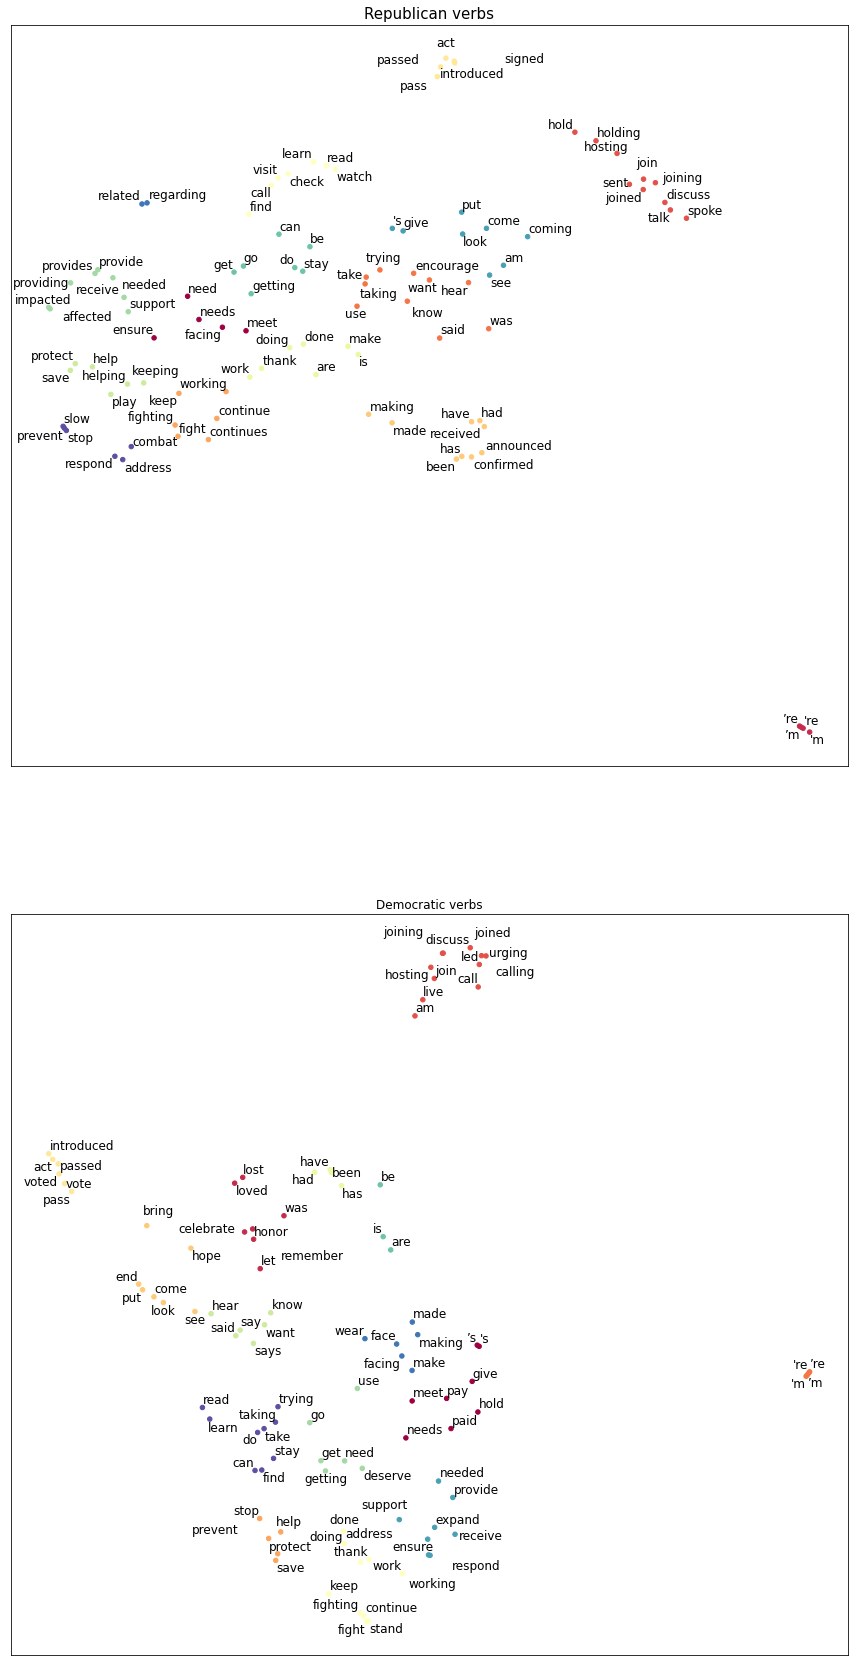

In [32]:
plt.figure(figsize=(15,30))
plt.subplot(2,1,1)
x = df_verb_rep['umap_emb_x'].tolist()
y = df_verb_rep['umap_emb_y'].tolist()
l = df_verb_rep['cluster'].tolist()
text = df_verb_rep['Verb'].tolist()
plt.scatter(x,y, s=20, c=l, cmap='Spectral')
texts = [plt.text(x[idx], y[idx], text[idx], fontsize=12) for idx in range(len(text))]
adjust_text(texts, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), save_steps=True, lim=20)
plt.xticks([])
plt.yticks([])
plt.title('Republican verbs', fontsize=15)

plt.subplot(2,1,2)
x = df_verb_dem['umap_emb_x'].tolist()
y = df_verb_dem['umap_emb_y'].tolist()
l = df_verb_dem['cluster'].tolist()
text = df_verb_dem['Verb'].tolist()
plt.scatter(x,y, s=20, c=l, cmap='Spectral')
texts = [plt.text(x[idx], y[idx], text[idx], fontsize=12) for idx in range(len(text))]
adjust_text(texts, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), save_steps=True, lim=20)
plt.title('Democratic verbs')
plt.xticks([])
plt.yticks([])
plt.savefig('verb_clusters.pdf', format='pdf', fontsize=15)
# plt.savefig('rep_verbs.png', format='png')

In [30]:
def extract_verb_agents(df, verb_list, arg_option):
    # look at the embeddings of a specific verb
    df_verb = df[df.Verb.isin(verb_list)]
    df_verb = df_verb[df_verb['Arg{}_idx'.format(arg_option)] != -1]

#     df_verb_agg = df_verb.groupby('Arg{}_tok'.format(arg_option))\
#             .head(1)[['Arg{}_tok'.format(arg_option), 'Arg{}_emb'.format(arg_option)]]
#     df_verb_agg = df_verb_agg[df_verb_agg.apply(lambda row: row['Arg{}_emb'\
#                                                                 .format(arg_option)].shape[0] == 1, axis=1)]
#     arr = np.asarray(df_verb_agg['Arg{}_emb'.format(arg_option)].tolist()).squeeze()
#     print(arr.shape)
#     dim = min(arr.shape[0]-10, 50)
#     umap_reduc = umap.UMAP(n_components=dim).fit_transform(arr)
#     pca_reduc = PCA(n_components=2).fit_transform(umap_reduc)
#     df_verb_agg['emb_x'] = pca_reduc[:,0]
#     df_verb_agg['emb_y'] = pca_reduc[:,1]
    return df_verb

In [31]:
talk_verb_list = [ 'discuss', 'spoke', 'sent', 'joined', 
            'talk', 'joining', 'join']

In [32]:
rep_talk_arg0 = extract_verb_agents(df_args_rep, talk_verb_list, 0)

In [33]:
rep_talk_arg1 = extract_verb_agents(df_args_rep, talk_verb_list, 1)

In [34]:
import networkx as nx

In [35]:
G = nx.Graph()

In [36]:
rep_talk_arg0.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
300,joined,1,"[0.636559, -0.504189, 0.371439, 0.208523, -0.8...",i,[0],"[[0.0022316546260752494, 0.002160149203758373,...",several senators,"[2, 3]","[[0.006243967739299262, 0.004682119237539398, ..."
317,joined,39,"[0.636559, -0.504189, 0.371439, 0.208523, -0.8...",american ppl rs,"[36, 37, 38]","[[0.006086689046646298, 0.0004938113404689549,...",dems,[40],"[[0.003352129803249948, 0.0020714956984408165,..."


In [37]:
rep_talk_edges = pd.concat([rep_talk_arg0, rep_talk_arg1])

In [38]:
rep_talk_edges.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
300,joined,1,"[0.636559, -0.504189, 0.371439, 0.208523, -0.8...",i,[0],"[[0.0022316546260752494, 0.002160149203758373,...",several senators,"[2, 3]","[[0.006243967739299262, 0.004682119237539398, ..."
317,joined,39,"[0.636559, -0.504189, 0.371439, 0.208523, -0.8...",american ppl rs,"[36, 37, 38]","[[0.006086689046646298, 0.0004938113404689549,...",dems,[40],"[[0.003352129803249948, 0.0020714956984408165,..."


In [39]:
len(rep_talk_edges)

12475

In [40]:
rep_talk_edges = rep_talk_edges[rep_talk_edges['Arg0_idx'] != -1]
rep_talk_edges = rep_talk_edges[rep_talk_edges['Arg1_idx'] != -1]

In [41]:
len(rep_talk_edges)

5506

In [42]:
rep_talk_edges = rep_talk_edges[['Arg0_tok', 'Arg1_tok']]

In [43]:
rep_talk_edges.columns = ['Source', 'Target']

In [44]:
rep_talk_edges.head(2)

,Source,Target
300,i,several senators
317,american ppl rs,dems


In [45]:
rep_talk_edges = rep_talk_edges.groupby(['Source', 'Target']).size().reset_index()

In [46]:
rep_talk_edges.columns = ['Source', 'Target', 'Weight']

In [47]:
# rep_talk_edges.to_csv('rep_talk_edges.csv', index=False)

In [48]:
G.add_edges_from(rep_talk_edges[['Source', 'Target']].values)

In [49]:
G

In [50]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

In [51]:
import community as community_louvain


In [52]:
#first compute the best partition
partition = community_louvain.best_partition(G)



In [75]:
comm = pd.DataFrame.from_dict(partition, orient='index').reset_index()
comm.columns=['node', 'cluster']

In [80]:
for i in range(90):
    print(comm[comm['cluster']==i].node.tolist())
    print()

['# aacu', 'the @amerurological']

['waysmeansgop', 'ideas']

['# new @johncornyn', '@cityoffortworth priorities']

["'s", 'about modeling']

['( 8a est', '@cbsthismorning']

['85 members', '@repadriansmith']

["?? alert!i'll", '@oann']

['?? live tv', '@americanewsroom']

['@77wabcradio', 'the crit']

['@abcnewslive', 'the u.', 'saudi arabia']

['@aclatam', 'opportunities to']

['@ajitpaifcc', 'a @housecommerce briefing']

['@apple', 'forces', '@google and @apple', '@gopoversight', 'the letter', '@govricketts', '@jaketapper', '@tperkins', '@hawleymo', 'a letter', '@repdustyjohnson and i', '@repwalberg', '@sensasse', '@wandavazquezg', 'by @congpalazzo', 'we', 'by dr', 'by lt', 'by our faith', 'him', 'which priorities', '@mysuncoast', 'a bipartisan letter', 'it?the media', 'a', 'la tienda', 'ntu', 'parents', 'it', 'rt', 'russia and iran', 'state lawmakers', 'the taliban', '@massbio', '@phoenixpolice', '@vp mike pence', 'a little', 'about # ppe', 'about # socialdistancing', 'about human 

In [76]:
import matplotlib.cm as cm


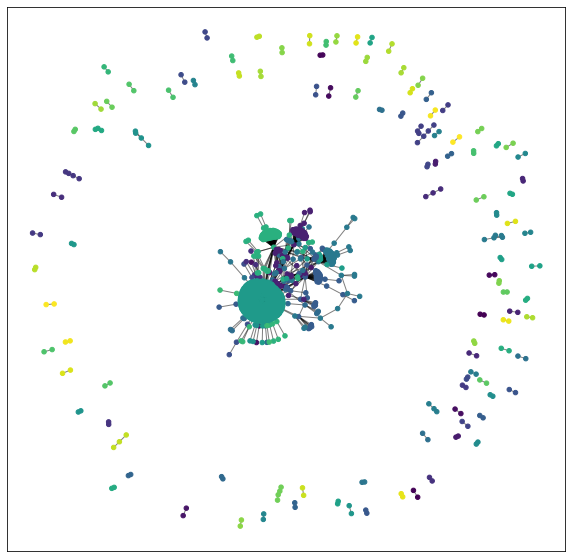

In [58]:
# draw the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
